# Explainable AI

In [26]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgbm

import pickle

pd.set_option('display.max_columns', None)

In [2]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs  
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import to_categorical

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())

Instructions for updating:
non-resource variables are not supported in the long term
TF version:  2.1.0
Eager execution enabled:  False


## Carregar base de dados

In [3]:
PATH = '../data/processed/'

In [4]:
dataset = pd.read_csv(os.path.join(PATH, 'dataset2.csv'), sep=',')
print(dataset.shape)
dataset.head()

(4523, 59)


,BOM,RUIM,DESEMPENHO_ESC,CD_ESCOLA,CAPITAL,AREA,ESTIMATED_POP,RURAL_URBAN,GVA_PUBLIC,GDP_CAPITA,DEPENDENCIAS_SALAS_AULA,DEPENDENCIAS_TOT_SALA_LEITURA,DEPENDENCIAS_SALA_PROF,DEPENDENCIAS_LAB_INFO,DEPENDENCIAS_TOT_LAB_CIENCIA,FORMACAO_APERF/EXTENSIAOCULTURAL,FORMACAO_BACHARELADO/TECNIOLOGO,FORMACAO_DOUTORADO,FORMACAO_ENSINO_MEDIO,FORMACAO_ESPECIALIZACAO,FORMACAO_LICENCIATURA,FORMACAO_MESTRADO,FORMACAO_S/INFO,QTD_SERVIDORES,QTD_PROFESSORES,MEDIA_FORMACOES,QTD_FORMACAO_CONTINUADA,QTD_CARGOS_DISTINTOS,QTD_TOTAL_ALUNOS,QTD_CLASSES,MEDIA_ALUNOS_SALA,QTD_CLASSES_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_CLASSES_TIPO_ENSINO MEDIO,QTD_ALUNOS_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_ALUNOS_TIPO_ENSINO MEDIO,DIRETORES_QTD_2018,COORDENADORES_QTD_2018,DIRETORES_QTD_5_ANOS,COORDENADORES_QTD_5_ANOS,DIRETOR_IDADE,DIRETOR_CARGO_CLAS_EXER_IGUAIS,DIRETOR_ANOS_TRAB_CARGO_C,DIRETOR_ANOS_TRAB_CARGO_E,JORNADA_QTD_DISCIPLINAS_mean,JORNADA_QTD_DISCIPLINAS_max,JORNADA_QTD_TOTAL_AULAS_mean,JORNADA_QTD_TOTAL_AULAS_max,SERVIDORES_IDADE_mean,SERVIDORES_TEMPO_CARGO_C_mean,SERVIDORES_CAT_FUNCIONAL_A,SERVIDORES_CAT_FUNCIONAL_F,SERVIDORES_CAT_FUNCIONAL_N,SERVIDORES_CAT_FUNCIONAL_O,SERVIDORES_CAT_FUNCIONAL_P,MATEMATICA,LEITURA,ESCRITA,RELACAO_ALUNO_POR_SERVIDOR,RELACAO_ALUNO_POR_PROFESSOR
0,1.0,7.0,0,24,1,1521.11,12176866.0,Urbano,41902892.72,57071.43,35,1,1,2,1,0.0,0.101695,0.008475,0.016949,0.016949,0.771186,0.084746,0.0,139,118,1.228814,13,6,2703,88,30.715909,34.0,40.0,956.0,1229.0,3.0,3.0,11.0,17.0,33.0,1,0.0,0.0,3.486726,10,48.849558,108,47.024096,10.819277,0.789157,0.144578,0.0,0.066265,0.0,4.0,3.0,4.0,19.446043,22.906780
1,0.0,4.0,0,36,1,1521.11,12176866.0,Urbano,41902892.72,57071.43,21,1,1,2,1,0.0,0.095238,0.011905,0.000000,0.142857,0.738095,0.011905,0.0,92,84,1.297619,14,4,2164,69,31.362319,34.0,29.0,1189.0,945.0,4.0,3.0,13.0,13.0,50.0,0,18.0,0.0,2.975000,8,46.525000,104,45.460784,8.598039,0.754902,0.176471,0.0,0.068627,0.0,4.0,3.0,4.0,23.521739,25.761905
2,0.0,2.0,0,48,1,1521.11,12176866.0,Urbano,41902892.72,57071.43,19,1,1,2,2,0.0,0.090909,0.018182,0.000000,0.018182,0.836364,0.036364,0.0,66,55,1.163636,4,5,1189,35,33.971429,0.0,35.0,0.0,1189.0,2.0,2.0,8.0,10.0,58.0,0,18.0,2.0,2.125000,4,44.375000,64,45.744681,9.361702,0.851064,0.106383,0.0,0.042553,0.0,4.0,3.0,4.0,18.015152,21.618182
3,0.0,2.0,0,59,1,1521.11,12176866.0,Urbano,41902892.72,57071.43,11,1,1,1,1,0.0,0.093023,0.000000,0.000000,0.023256,0.813953,0.069767,0.0,49,43,1.209302,4,4,974,28,34.785714,0.0,28.0,0.0,974.0,4.0,1.0,12.0,6.0,38.0,0,10.0,0.0,2.150000,4,42.500000,98,42.972973,7.810811,0.783784,0.135135,0.0,0.081081,0.0,4.0,3.0,4.0,19.877551,22.651163
4,3.0,1.0,1,61,1,1521.11,12176866.0,Urbano,41902892.72,57071.43,15,1,1,1,0,0.0,0.039216,0.000000,0.098039,0.039216,0.803922,0.019608,0.0,59,51,1.078431,3,4,909,33,27.545455,30.0,0.0,897.0,0.0,2.0,2.0,10.0,8.0,53.0,1,9.0,9.0,2.488889,4,48.755556,64,47.955556,11.400000,0.600000,0.155556,0.0,0.244444,0.0,4.0,3.0,4.0,15.406780,17.823529


#### Remover a coluna de identificação *CD_ESCOLA* e os atributos *BOM* e *RUIM* que foram utilizados para construir a classe alvo
Cada linha representa uma escola, apesar da remoção de CD_ESCOLA, que é necessário já que este não é um atributo para predizer o desempenho escolar, é possível identificar o resultado da predição da escola com os índices do dataset, que permite localizar o *CD_ESCOLA* posteriormente

In [5]:
dataset.drop(['BOM', 'RUIM', 'CD_ESCOLA'], axis=1, inplace=True)

### Renomear a coluna *DESEMPENHO_ESC* para *DESEMPENHO*

In [6]:
dataset = dataset.rename(columns={'DESEMPENHO_ESC': 'DESEMPENHO'})

## Seleção de Atributos

In [12]:
print(dataset.shape)
dataset.head()

(4523, 59)


,DIRETOR_CARGO_CLAS_EXER_IGUAIS_0,DIRETOR_CARGO_CLAS_EXER_IGUAIS_1,RURAL_URBAN_0,RURAL_URBAN_1,CAPITAL_0,CAPITAL_1,DESEMPENHO,AREA,ESTIMATED_POP,GVA_PUBLIC,GDP_CAPITA,DEPENDENCIAS_SALAS_AULA,DEPENDENCIAS_TOT_SALA_LEITURA,DEPENDENCIAS_SALA_PROF,DEPENDENCIAS_LAB_INFO,DEPENDENCIAS_TOT_LAB_CIENCIA,FORMACAO_APERF/EXTENSIAOCULTURAL,FORMACAO_BACHARELADO/TECNIOLOGO,FORMACAO_DOUTORADO,FORMACAO_ENSINO_MEDIO,FORMACAO_ESPECIALIZACAO,FORMACAO_LICENCIATURA,FORMACAO_MESTRADO,FORMACAO_S/INFO,QTD_SERVIDORES,QTD_PROFESSORES,MEDIA_FORMACOES,QTD_FORMACAO_CONTINUADA,QTD_CARGOS_DISTINTOS,QTD_TOTAL_ALUNOS,QTD_CLASSES,MEDIA_ALUNOS_SALA,QTD_CLASSES_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_CLASSES_TIPO_ENSINO MEDIO,QTD_ALUNOS_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_ALUNOS_TIPO_ENSINO MEDIO,DIRETORES_QTD_2018,COORDENADORES_QTD_2018,DIRETORES_QTD_5_ANOS,COORDENADORES_QTD_5_ANOS,DIRETOR_IDADE,DIRETOR_ANOS_TRAB_CARGO_C,DIRETOR_ANOS_TRAB_CARGO_E,JORNADA_QTD_DISCIPLINAS_mean,JORNADA_QTD_DISCIPLINAS_max,JORNADA_QTD_TOTAL_AULAS_mean,JORNADA_QTD_TOTAL_AULAS_max,SERVIDORES_IDADE_mean,SERVIDORES_TEMPO_CARGO_C_mean,SERVIDORES_CAT_FUNCIONAL_A,SERVIDORES_CAT_FUNCIONAL_F,SERVIDORES_CAT_FUNCIONAL_N,SERVIDORES_CAT_FUNCIONAL_O,SERVIDORES_CAT_FUNCIONAL_P,MATEMATICA,LEITURA,ESCRITA,RELACAO_ALUNO_POR_SERVIDOR,RELACAO_ALUNO_POR_PROFESSOR
0,0,1,0,1,0,1,0,1521.11,12176866.0,41902892.72,57071.43,35,1,1,2,1,0.0,0.101695,0.008475,0.016949,0.016949,0.771186,0.084746,0.0,139,118,1.228814,13,6,2703,88,30.715909,34.0,40.0,956.0,1229.0,3.0,3.0,11.0,17.0,33.0,0.0,0.0,3.486726,10,48.849558,108,47.024096,10.819277,0.789157,0.144578,0.0,0.066265,0.0,4.0,3.0,4.0,19.446043,22.906780
1,1,0,0,1,0,1,0,1521.11,12176866.0,41902892.72,57071.43,21,1,1,2,1,0.0,0.095238,0.011905,0.000000,0.142857,0.738095,0.011905,0.0,92,84,1.297619,14,4,2164,69,31.362319,34.0,29.0,1189.0,945.0,4.0,3.0,13.0,13.0,50.0,18.0,0.0,2.975000,8,46.525000,104,45.460784,8.598039,0.754902,0.176471,0.0,0.068627,0.0,4.0,3.0,4.0,23.521739,25.761905
2,1,0,0,1,0,1,0,1521.11,12176866.0,41902892.72,57071.43,19,1,1,2,2,0.0,0.090909,0.018182,0.000000,0.018182,0.836364,0.036364,0.0,66,55,1.163636,4,5,1189,35,33.971429,0.0,35.0,0.0,1189.0,2.0,2.0,8.0,10.0,58.0,18.0,2.0,2.125000,4,44.375000,64,45.744681,9.361702,0.851064,0.106383,0.0,0.042553,0.0,4.0,3.0,4.0,18.015152,21.618182
3,1,0,0,1,0,1,0,1521.11,12176866.0,41902892.72,57071.43,11,1,1,1,1,0.0,0.093023,0.000000,0.000000,0.023256,0.813953,0.069767,0.0,49,43,1.209302,4,4,974,28,34.785714,0.0,28.0,0.0,974.0,4.0,1.0,12.0,6.0,38.0,10.0,0.0,2.150000,4,42.500000,98,42.972973,7.810811,0.783784,0.135135,0.0,0.081081,0.0,4.0,3.0,4.0,19.877551,22.651163
4,0,1,0,1,0,1,1,1521.11,12176866.0,41902892.72,57071.43,15,1,1,1,0,0.0,0.039216,0.000000,0.098039,0.039216,0.803922,0.019608,0.0,59,51,1.078431,3,4,909,33,27.545455,30.0,0.0,897.0,0.0,2.0,2.0,10.0,8.0,53.0,9.0,9.0,2.488889,4,48.755556,64,47.955556,11.400000,0.600000,0.155556,0.0,0.244444,0.0,4.0,3.0,4.0,15.406780,17.823529


## Mudança nos nomes dos atributos

In [13]:
cols = dataset.columns

In [14]:
cols = cols.str.replace('mean', 'MEDIA')

In [15]:
cols = cols.str.upper()

In [16]:
cols = cols.str.replace('_', ' ')

In [17]:
cols = cols.str.replace('GDP CAPITA', 'MUNICIPIO PIB PER CAPITA')
cols = cols.str.replace('GVA PUBLIC', 'MUNICIPIO VALOR ACRESCENTADO BRUTO')
cols = cols.str.replace('RURAL', 'MUNICIPIO RURAL')
cols = cols.str.replace('AREA', 'MUNICIPIO CAPITAL')
cols = cols.str.replace('CAPITAL', 'MUNICIPIO AREA')
cols = cols.str.replace('ESTIMATED POP', 'MUNICIPIO ESTIMATED POP')
cols = cols.str.replace('FUNDAMENTAL DE 9 ANOS', 'FUNDAMENTAL')
cols = cols.str.replace('MATEMATICA', 'ANA MATEMATICA')
cols = cols.str.replace('LEITURA', 'ANA LEITURA')
cols = cols.str.replace('ESCRITA', 'ANA ESCRITA')

In [18]:
cols.tolist()

['DIRETOR CARGO CLAS EXER IGUAIS 0',
 'DIRETOR CARGO CLAS EXER IGUAIS 1',
 'MUNICIPIO RURAL URBAN 0',
 'MUNICIPIO RURAL URBAN 1',
 'MUNICIPIO AREA 0',
 'MUNICIPIO AREA 1',
 'DESEMPENHO',
 'MUNICIPIO MUNICIPIO AREA',
 'MUNICIPIO ESTIMATED POP',
 'MUNICIPIO VALOR ACRESCENTADO BRUTO',
 'MUNICIPIO PIB PER CAPITA',
 'DEPENDENCIAS SALAS AULA',
 'DEPENDENCIAS TOT SALA ANA LEITURA',
 'DEPENDENCIAS SALA PROF',
 'DEPENDENCIAS LAB INFO',
 'DEPENDENCIAS TOT LAB CIENCIA',
 'FORMACAO APERF/EXTENSIAOCULTURAL',
 'FORMACAO BACHARELADO/TECNIOLOGO',
 'FORMACAO DOUTORADO',
 'FORMACAO ENSINO MEDIO',
 'FORMACAO ESPECIALIZACAO',
 'FORMACAO LICENCIATURA',
 'FORMACAO MESTRADO',
 'FORMACAO S/INFO',
 'QTD SERVIDORES',
 'QTD PROFESSORES',
 'MEDIA FORMACOES',
 'QTD FORMACAO CONTINUADA',
 'QTD CARGOS DISTINTOS',
 'QTD TOTAL ALUNOS',
 'QTD CLASSES',
 'MEDIA ALUNOS SALA',
 'QTD CLASSES TIPO ENSINO FUNDAMENTAL',
 'QTD CLASSES TIPO ENSINO MEDIO',
 'QTD ALUNOS TIPO ENSINO FUNDAMENTAL',
 'QTD ALUNOS TIPO ENSINO MEDIO',
 

In [19]:
dataset.columns = cols

## Separacao dos dados
- Treinamento: 80%
- Teste: 20%

In [20]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('DESEMPENHO', axis=1), dataset['DESEMPENHO'], test_size=0.2, random_state=17)

## Normalização

In [21]:
feature_range = (0, 1)
scaler = MinMaxScaler(feature_range)

feature_cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=feature_cols, index=y_train.index)

In [22]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_cols, index=y_test.index)

In [23]:
cat_cols_ohe = [c for c in X_test.columns for cat in categorical_cols if cat in c]

In [24]:
X_train[cat_cols_ohe] = X_train[cat_cols_ohe].apply(lambda x: x.astype(int))
X_test[cat_cols_ohe] = X_test[cat_cols_ohe].apply(lambda x: x.astype(int))

### Salvar dataset final

In [54]:
df_features = pd.concat([X_train, X_test])
df_features.loc[X_train.index, 'set_type'] = 'train'
df_features.loc[X_test.index, 'set_type'] = 'test'

In [55]:
df_targets = pd.concat([y_train, y_test])
df_targets = df_targets.rename('target')

In [60]:
df_final_dataset = pd.concat([df_features, df_targets], axis=1)
df_final_dataset.sort_index(inplace=True)
df_final_dataset.to_csv('../data/processed/final_dataset.csv', index=False)

## Dataset processado

In [ ]:
# df_final_dataset.to_csv('../data/processed/final_dataset.csv', index=False)

## Modeling

### Validação Cruzada com 10 folds

In [27]:
model = lgbm.LGBMClassifier(random_state=17)
scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, n_jobs=-1)

print('Acuracia Media:', np.mean(scores))
print('Desvio Padrao:', np.std(scores))
print(scores)

Acuracia Media: 0.920118302444101
Desvio Padrao: 0.01300527795048722
[0.91436464 0.91712707 0.93646409 0.9198895  0.94751381 0.9281768
 0.90607735 0.90331492 0.91135734 0.91689751]


### Holdout

In [28]:
model = lgbm.LGBMClassifier(random_state=17)
model.fit(X_train, y_train)

LGBMClassifier(random_state=17)

In [29]:
pred = model.predict(X_test)
pred_scores = model.predict_proba(X_test)[:, 1]

Acc score: 0.932596685082873
F1 score: 0.8063492063492064
AUC ROC: 0.9684516396845163


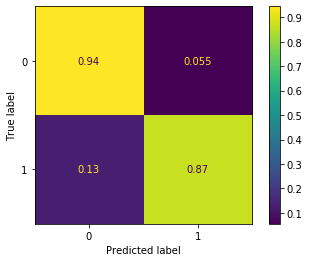

In [30]:
print('Acc score:', accuracy_score(y_test, pred))
print('F1 score:', f1_score(y_test, pred))
print('AUC ROC:', roc_auc_score(y_test, pred_scores))
plot_confusion_matrix(model, X_test, y_test, normalize='true')

# XAI

In [31]:
import shap

import lime
import lime.lime_tabular

from alibi.explainers import CounterFactualProto

shap.initjs()

In [32]:
df_pred_scores = (pd.DataFrame(model.predict_proba(X_test), columns=["RUIM", "BOM"]) * 100).round(2)

In [33]:
df_results = pd.concat([df_pred_scores, pd.Series(model.predict(X_test), name="CLASSE"),  y_test.reset_index(drop=True)], axis=1)

In [34]:
df_results[(df_results['RUIM'] > 50) & (df_results['RUIM'] < 80)].sample(15)
# d = [429, 113, 781, 541,804, 298]

,RUIM,BOM,CLASSE,DESEMPENHO
35,78.63,21.37,0,1
830,76.76,23.24,0,0
97,77.02,22.98,0,0
298,62.32,37.68,0,0
240,63.33,36.67,0,0
875,58.10,41.90,0,1
87,57.38,42.62,0,1
476,78.48,21.52,0,0
100,50.44,49.56,0,0
199,69.53,30.47,0,0


In [35]:
bad_list_for_test = [760, 161, 476, 904, 381, 199, 634, 97, 298, 490, 830]

In [36]:
df_results[(df_results['RUIM'] < 50) & (df_results['RUIM'] > 15)].sample(15)

,RUIM,BOM,CLASSE,DESEMPENHO
860,24.86,75.14,1,1
274,19.66,80.34,1,1
874,27.63,72.37,1,0
216,28.98,71.02,1,1
665,45.24,54.76,1,0
83,37.19,62.81,1,1
52,27.73,72.27,1,1
372,23.27,76.73,1,0
593,21.22,78.78,1,1
134,39.72,60.28,1,0


In [37]:
good_list_for_test = [513, 567, 304, 860, 216, 325, 866, 356, 304]

## SHAP

### Global

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


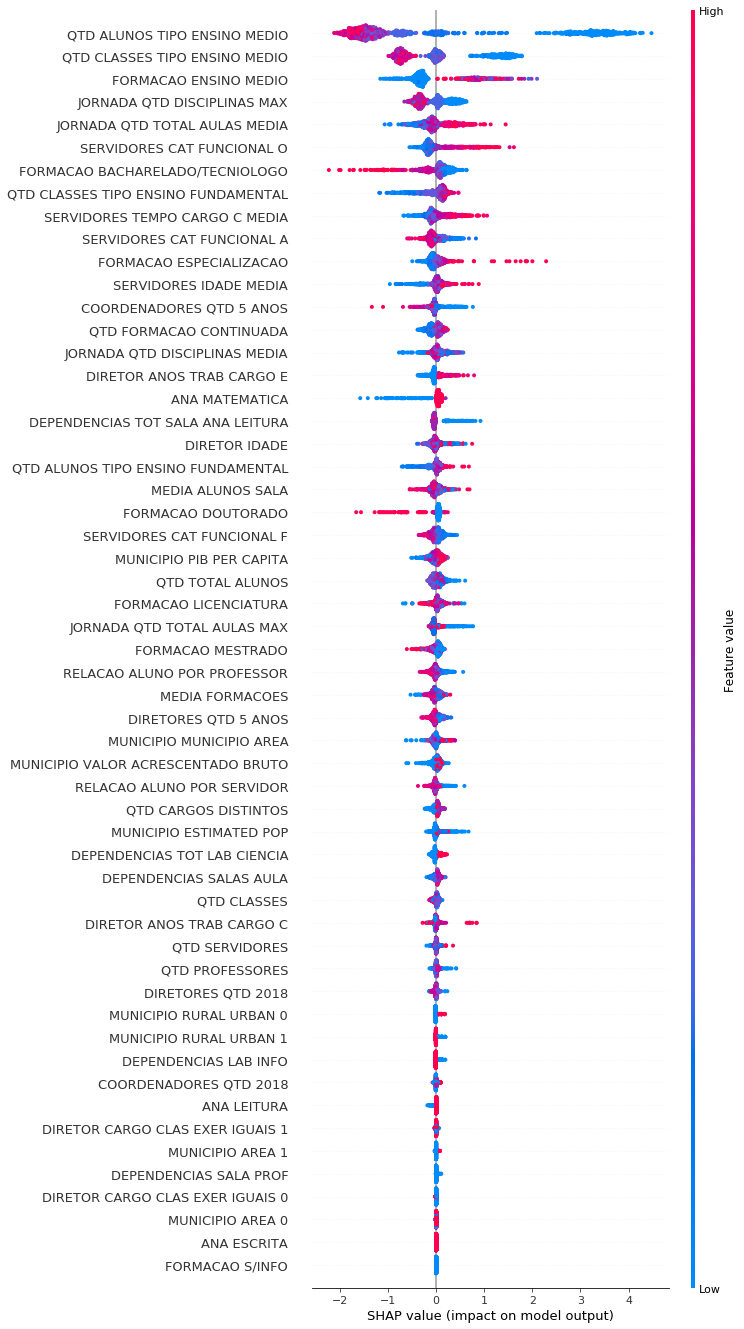

In [38]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, max_display=55)

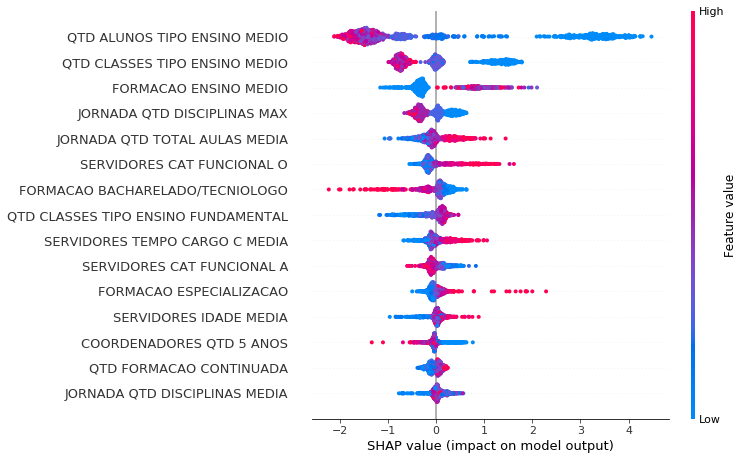

In [39]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, max_display=15)

### Local

In [40]:
idx_good = 304

In [41]:
X_test.iloc[[idx_good]]

,DIRETOR CARGO CLAS EXER IGUAIS 0,DIRETOR CARGO CLAS EXER IGUAIS 1,MUNICIPIO RURAL URBAN 0,MUNICIPIO RURAL URBAN 1,MUNICIPIO AREA 0,MUNICIPIO AREA 1,MUNICIPIO MUNICIPIO AREA,MUNICIPIO ESTIMATED POP,MUNICIPIO VALOR ACRESCENTADO BRUTO,MUNICIPIO PIB PER CAPITA,DEPENDENCIAS SALAS AULA,DEPENDENCIAS TOT SALA ANA LEITURA,DEPENDENCIAS SALA PROF,DEPENDENCIAS LAB INFO,DEPENDENCIAS TOT LAB CIENCIA,FORMACAO APERF/EXTENSIAOCULTURAL,FORMACAO BACHARELADO/TECNIOLOGO,FORMACAO DOUTORADO,FORMACAO ENSINO MEDIO,FORMACAO ESPECIALIZACAO,FORMACAO LICENCIATURA,FORMACAO MESTRADO,FORMACAO S/INFO,QTD SERVIDORES,QTD PROFESSORES,MEDIA FORMACOES,QTD FORMACAO CONTINUADA,QTD CARGOS DISTINTOS,QTD TOTAL ALUNOS,QTD CLASSES,MEDIA ALUNOS SALA,QTD CLASSES TIPO ENSINO FUNDAMENTAL,QTD CLASSES TIPO ENSINO MEDIO,QTD ALUNOS TIPO ENSINO FUNDAMENTAL,QTD ALUNOS TIPO ENSINO MEDIO,DIRETORES QTD 2018,COORDENADORES QTD 2018,DIRETORES QTD 5 ANOS,COORDENADORES QTD 5 ANOS,DIRETOR IDADE,DIRETOR ANOS TRAB CARGO C,DIRETOR ANOS TRAB CARGO E,JORNADA QTD DISCIPLINAS MEDIA,JORNADA QTD DISCIPLINAS MAX,JORNADA QTD TOTAL AULAS MEDIA,JORNADA QTD TOTAL AULAS MAX,SERVIDORES IDADE MEDIA,SERVIDORES TEMPO CARGO C MEDIA,SERVIDORES CAT FUNCIONAL A,SERVIDORES CAT FUNCIONAL F,SERVIDORES CAT FUNCIONAL N,SERVIDORES CAT FUNCIONAL O,SERVIDORES CAT FUNCIONAL P,ANA MATEMATICA,ANA LEITURA,ANA ESCRITA,RELACAO ALUNO POR SERVIDOR,RELACAO ALUNO POR PROFESSOR
4032,0.0,1.0,1.0,0.0,1.0,0.0,0.162684,0.000418,0.000577,0.049179,0.125,0.25,0.25,0.2,0.0,0.0,0.10119,0.0,0.260417,0.160714,0.678571,0.0,0.0,0.111111,0.102941,0.160714,0.107143,0.4,0.096322,0.142857,0.373408,0.245283,0.0,0.167964,0.0,0.285714,0.333333,0.631579,0.172414,0.545455,0.347826,0.347826,0.241546,0.111111,0.689189,0.434783,0.551588,0.282609,0.478261,0.086957,0.0,0.434783,0.0,1.0,0.75,0.8,0.323679,0.339138


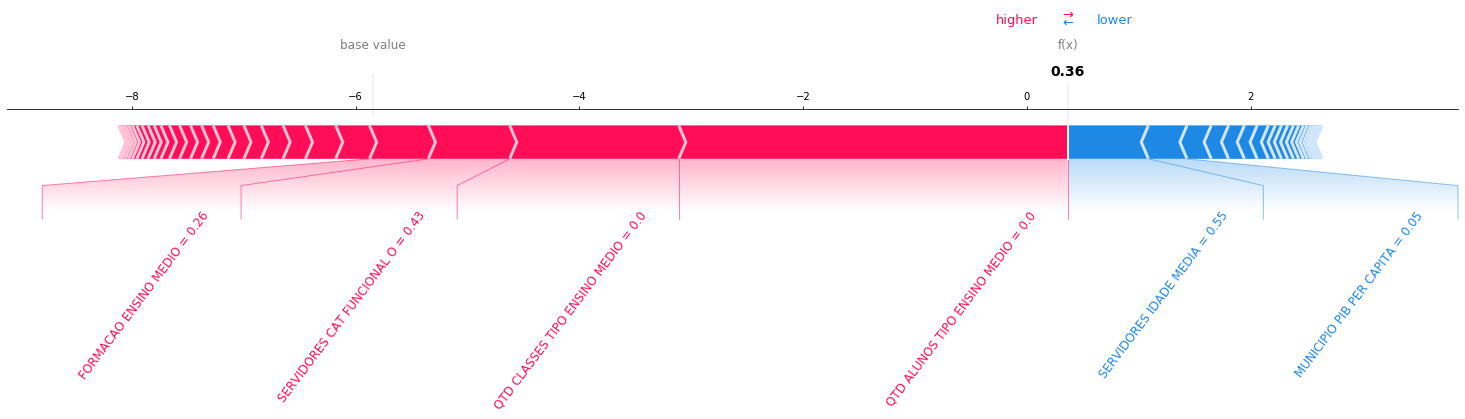

In [43]:
fig = shap.force_plot(explainer.expected_value[1], shap_values[1][idx_good,:], X_test.iloc[idx_good,:].round(2), figsize=(26,4), text_rotation=53, matplotlib=True, show=False)

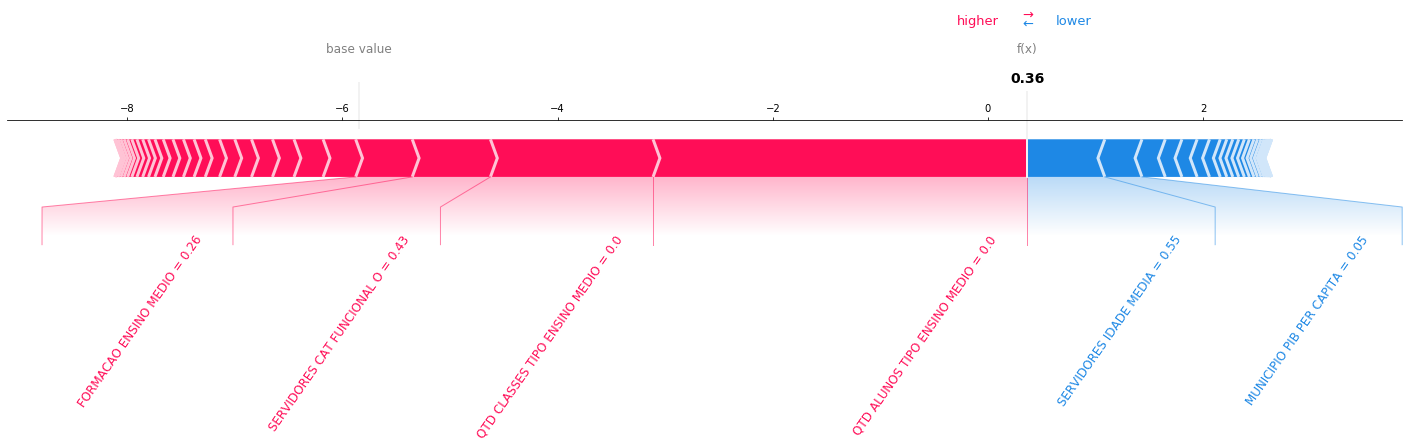

In [44]:
fig = shap.force_plot(explainer.expected_value[1], shap_values[1][idx_good,:], X_test.iloc[idx_good,:].round(2), figsize=(25,4.5), text_rotation=55, matplotlib=True, show=False)
plt.savefig("shap_local_fontsize3.png", bbox_inches = 'tight', dpi=200, transparent=True)

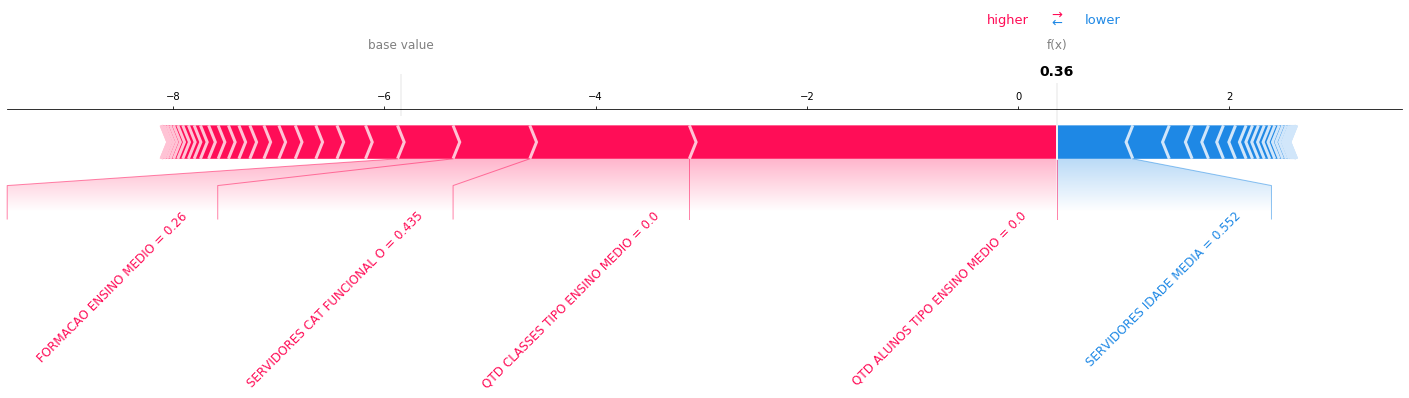

In [45]:
fig = shap.force_plot(explainer.expected_value[1], shap_values[1][idx_good,:], X_test.iloc[idx_good,:].round(3), figsize=(25,4), text_rotation=45, matplotlib=True, show=False)
# plt.savefig("shap_local_novo.png", bbox_inches = 'tight')

# Contrafactual

In [70]:
def create_dataframe_instances(X_idx, X_new, name):
    idx = X_idx.index[0]
    Xpn = X_new #explanation['cf']['X']

    classes = [ class_names[np.argmax(model.predict_proba(X_idx))], class_names[np.argmax(model.predict_proba(Xpn))], 'NULL' ]


    delta_re = Xpn - X_idx.values
    delta_re = np.around(delta_re.astype(np.double), 5)
    delta_re[np.absolute(delta_re) < 1e-5] = 0

    X_idx_df = X_idx.iloc[0]
    Xpn_df = pd.Series(Xpn[0], index=X_train.columns)
    delta_re_df = pd.Series(delta_re[0], index=X_train.columns)

    X_idx_df.name = 'X'
    Xpn_df.name = name
    delta_re_df.name = name + ' - X'
    
    
    dfre = pd.concat([X_idx_df, Xpn_df, delta_re_df], axis=1)
    dfre.loc['Class', :] = classes
    
    return dfre

In [63]:
def highlight_ce(s, col, ncols):
        if (type(s[col]) != str):
            if (s[col] > 0):
                return(['background-color: #fae68d']*ncols)    
            if (s[col] < 0):
                return(['background-color: #f94852']*ncols)    
        return(['background-color: white']*ncols)

In [48]:
shape = X_test.iloc[[0]].shape
cat_cols_dict = {0: 2, 2: 2, 4: 2}

In [49]:
rng = feature_range
rng_shape = (1,) + (shape[1] - len(cat_cols_dict.keys()),)
feature_range_numeric = ((np.ones(rng_shape) * rng[0]).astype(np.float32), (np.ones(rng_shape) * rng[1]).astype(np.float32))

In [54]:
idx = 634

In [55]:
cf = CounterFactualProto(
    lambda x: model.predict_proba(x),
    shape,
    beta=.01,
    cat_vars=cat_cols_dict,
    ohe=True,
    max_iterations=500,
    feature_range=feature_range_numeric,
    c_init=1.,
    c_steps=5
)

cf.fit(X_train.values)
explanation = cf.explain(X_test.iloc[[idx]].values)

In [57]:
X_cf = explanation['cf']['X']

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.


In [58]:
class_names = ['RUIM', 'BOM']

In [64]:
pred_class_original = explanation['orig_class']
proba_original = explanation['orig_proba'][0][pred_class_original]

print(f'Original prediction: {pred_class_original} with probability {proba_original}') 

pred_class_cf = explanation.cf['class']
proba_cf = explanation.cf['proba'][0][pred_class_cf]

print(f'Counterfactual prediction: {pred_class_cf} with probability {proba_cf}')

Original prediction: 0 with probability 0.760809661936144
Counterfactual prediction: 1 with probability 0.641971490899561


The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.


In [71]:
df_result = create_dataframe_instances(X_test.iloc[[idx]], X_cf, 'CF')
df_result.style.apply(highlight_ce, col='CF - X', ncols=3, axis=1)

,X,CF,CF - X
DIRETOR CARGO CLAS EXER IGUAIS 0,1.000000,1.000000,0.000000
DIRETOR CARGO CLAS EXER IGUAIS 1,0.000000,0.000000,0.000000
MUNICIPIO RURAL URBAN 0,0.000000,0.000000,0.000000
MUNICIPIO RURAL URBAN 1,1.000000,1.000000,0.000000
MUNICIPIO AREA 0,0.000000,0.000000,0.000000
MUNICIPIO AREA 1,1.000000,1.000000,0.000000
MUNICIPIO MUNICIPIO AREA,0.000751,0.000751,0.000000
MUNICIPIO ESTIMATED POP,1.000000,1.000000,0.000000
MUNICIPIO VALOR ACRESCENTADO BRUTO,1.000000,1.000000,0.000000
MUNICIPIO PIB PER CAPITA,0.159826,0.159826,0.000000
